## Notebook experimental
- Nesse exemplo estamos usando o SAM em sua versão original:
    - segmentação de 3 máscaras
    - uso de prompts esparços ou densos
    - uso de multimask_output

In [1]:
import os
from pathlib import Path
from typing import Optional
import numpy as np
import tqdm
from typing import List, Optional, Tuple
import gc
from copy import deepcopy
import matplotlib.pyplot as plt
import itertools

from matplotlib.colors import ListedColormap

import lightning as L
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.transforms.functional import resize, to_pil_image  # type: ignore
from torchmetrics import JaccardIndex
from torch.utils.data import Dataset

# from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.models.nets.image.sam import Sam
from minerva.data.datasets.supervised_dataset import SimpleDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.transforms.transform import _Transform#, TransformPipeline
from minerva.data.readers.reader import _Reader
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline

from lightning.pytorch.callbacks import ModelCheckpoint
from datetime import datetime
from lightning.pytorch.loggers import CSVLogger

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [2]:
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 4090


In [3]:
model_name = "SAM-ViT_B"

# f3
# train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
# annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

# parihaka
train_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seam_ai_datasets/seam_ai/annotations"

checkpoint_path = "/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth"

## Transform

In [4]:
class ResizeLongestSideCoords:
    """
    Resizes images to the longest side 'target_length', as well as provides
    methods for resizing coordinates. Provides methods for
    transforming both numpy array and batched torch tensors.
    """

    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_coords(self, coords: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_coords_torch(
        self, coords: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with length 2 in the last dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).to(torch.float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)

In [5]:
class Transpose(_Transform):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        # Verifica se a imagem tem a forma HxWxC
        if len(x.shape) == 3:  # HxWxC
            # Transpõe de HxWxC para CxHxW
            x_transposed = np.transpose(x, (2, 0, 1))
            x_transposed = torch.from_numpy(x_transposed).float()
        else:
            raise ValueError("Input image must have 3 dimensions (HxWxC)")

        return x_transposed

## Custom Dataset

In [6]:
class DatasetForSAM(SimpleDataset):
    def __init__(
            self, 
            readers: List[_Reader], 
            transforms: Optional[_Transform] = None,
            transform_coords_input:Optional[dict]=None,
            multimask_output:bool=True,
    ):
        """
        Custom Dataset to use properties that needed in images when send some image to SAM model.

        Parameters
        ----------
        readers: List[_Reader]
            List of data readers. It must contain exactly 2 readers.
            The first reader for the input data and the second reader for the
            target data.
        transforms: Optional[_Transform]
            Optional data transformation pipeline.
        transform_coords_input: Optional[dict] 
            List with transforms to apply.
                point_coords (np.ndarray or None): A Nx2 array of point prompts to the model. Each point is in (X,Y) in pixels.
                point_labels (np.ndarray or None): A length N array of labels for the point prompts. 1 indicates a foreground point and 0 indicates a background point.
    """
        super().__init__(readers, transforms)
        self.transform_coords_input = transform_coords_input
        self.multimask_output = multimask_output

        assert (
            len(self.readers) == 2
        ), "DatasetForSAM requires exactly 2 readers (image your label)"

        assert (
            len(self.readers) == len(self.transforms)
            and len(self.transforms) == len(self.transform_coords_input)
            and len(self.readers) == len(self.transform_coords_input)
        ), "DatasetForSAM requires exactly iquals lens (readers, transforms and transform_coords_input)"
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        """Load data and return data with SAM format (List[dict]), where dict have:
            'image' (required): The image as a torch tensor in 3xHxW format, already transformed for input to the model.
            'label' (required): The label of image as a torch tensor in 1xHxW format, already transformed for input to apply some metric (this is not needed to model, only to calculate metrics).
            'original_size' (required): (tuple(int, int)) The original size of the image before transformation, as (H, W).
            'point_coords' (optional): (torch.Tensor) Batched point prompts for this image, with shape BxNx2. Already transformed to the input frame of the model.
            'point_labels' (optional): (torch.Tensor) Batched labels for point prompts, with shape BxN. (0 is background, 1 is object and -1 is pad)
            'boxes' (optional): (torch.Tensor) Batched box inputs, with shape Bx4.  Already transformed to the input frame of the model.
            'mask_inputs' (optional): (torch.Tensor) Batched mask inputs to the model, in the form Bx1xHxW.
        """
        data_readers = []
        # apply transform to image
        for reader, transform in zip(self.readers, self.transforms):
            sample = reader[index]
            # Apply transform to image if is not None
            if transform is not None:
                sample = transform(sample)
            data_readers.append(sample)
        
        data = {}
        # apply transform_coords_input to image (only in the image, not in label)
        if self.transform_coords_input['point_coords'] is not None:
            image = self.readers[0][index]
            # TODO Implementar algum script que coloque pontos aleatoriamente nas fácies
            # point_coords = self.transform_coords_input['point_coords'].apply_coords(point_coords, self.original_size)
            # coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=self.device)
            # labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=self.device)
            # coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
            
            data['image'] = data_readers[0]
            data['label'] = data_readers[1]
            data['original_size'] = (int(image.shape[0]), int(image.shape[1]))
            # TODO OBS: Só pode passar esses pontos se aplicar o transform_coords. Se tentar passar como None vai dar erro no Dataloader.
            # data['point_coords'] = None
            # data['point_labels'] = None
            # data['boxes'] = None
            # data['mask_inputs'] = None

        return (data, self.multimask_output)

## Datamodule

In [7]:
class F3DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        transforms: _Transform = None,
        transform_coords_input: _Transform = None,
        multimask_output:bool = True,
        batch_size: int = 1,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.transform_coords_input = transform_coords_input
        self.multimask_output = multimask_output
        self.batch_size = batch_size
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.train_path / "train")
            train_label_reader = PNGReader(self.annotations_path / "train")
            train_dataset = DatasetForSAM(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
                transform_coords_input=self.transform_coords_input,
                multimask_output=self.multimask_output
            )

            val_img_reader = TiffReader(self.train_path / "val")
            val_label_reader = PNGReader(self.annotations_path / "val")
            val_dataset = DatasetForSAM(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
                transform_coords_input=self.transform_coords_input,
                multimask_output=self.multimask_output
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.train_path / "test")
            test_label_reader = PNGReader(self.annotations_path / "test")
            test_dataset = DatasetForSAM(
                readers=[test_img_reader, test_label_reader],
                transforms=self.transforms,
                transform_coords_input=self.transform_coords_input,
                multimask_output=self.multimask_output
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

In [8]:
data_module = F3DataModule(
    train_path=train_path,
    annotations_path=annotation_path,
    transforms=[Transpose(), None],
    transform_coords_input={'point_coords': ResizeLongestSideCoords(1024), 'point_labels': None},
    multimask_output=True,
    batch_size=1,
)

In [9]:
def get_train_dataloader(data_module):
    data_module.setup("fit")
    return data_module.train_dataloader()

print("Total batches: ", len(get_train_dataloader(data_module)))

train_batch, multimask_output = next(iter(get_train_dataloader(data_module)))
print("PRIMEIRO BATCH:")
print(f"Train batch image (X) shape: {train_batch['image'].shape}")
print(f"Train batch label (Y) shape: {train_batch['label'].shape}")
print(f"Train batch label (original_size) shape: {train_batch['original_size']}")
print(f"multimask_output: {multimask_output}")

Total batches:  1121


PRIMEIRO BATCH:
Train batch image (X) shape: torch.Size([1, 3, 1006, 531])
Train batch label (Y) shape: torch.Size([1, 1006, 531])
Train batch label (original_size) shape: [tensor([1006]), tensor([531])]
multimask_output: tensor([True])


In [10]:
print(f"O Batch (de tamanho {train_batch['image'].shape[0]}) possui: {train_batch['image'].shape[1]} canais, {train_batch['image'].shape[2]} altura e {train_batch['image'].shape[3]} largura.")

O Batch (de tamanho 1) possui: 3 canais, 1006 altura e 531 largura.


## Train with torch lightning and pipeline of Minerva

In [11]:
checkpoint_path

'/workspaces/Minerva-Discovery/shared_data/weights_sam/checkpoints_sam/sam_vit_b_01ec64.pth'

In [12]:
model = Sam(
    vit_type='vit-b',
    checkpoint=checkpoint_path,
    num_multimask_outputs=6, # default: 3
    iou_head_depth=6 # default: 3
)

/home/vscode/.local/lib/python3.10/site-packages/minerva/models/nets/image/sam.py:1362: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Error when load original weights. Applying now remaping.


In [13]:
current_date = datetime.now().strftime("%Y-%m-%d")

# Define o callback para salvar o modelo com base no menor valor da métrica de validação
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", # Métrica para monitorar
    dirpath="./checkpoints", # Diretório onde os checkpoints serão salvos
    filename=f"sam-{current_date}-{{epoch:02d}}-{{val_loss:.2f}}", # Nome do arquivo do checkpoint
    save_top_k=1, # Quantos melhores checkpoints salvar (no caso, o melhor)
    mode="min", # Como a métrica deve ser tratada (no caso, 'min' significa que menor valor de val_loss é melhor)
)

logger = CSVLogger("logs", name="sam")

trainer = L.Trainer(
    max_epochs=5,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Log directory set to: /workspaces/Minerva-Discovery/my_experiments/sam_original/logs/sam/version_66


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /workspaces/Minerva-Discovery/my_experiments/sam_original/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0      | train
1 | model   | _SAM             | 94.4 M | train
-----------------------------------------------------
94.4 M    Trainable params
0         Non-trainable params
94.4 M    Total params
377.415   Total estimated model params size (MB)
257       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/logs/sam/version_66/run_2024-12-05-21-17-1208afafa44a8949cf91f82a8100d2c6eb.yaml


## Testing

In [14]:
pipeline.run(data=data_module, task="test")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.39455369114875793    │
│         test_mIoU         │     0.657927930355072     │
└───────────────────────────┴───────────────────────────┘

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/logs/sam/version_66/run_2024-12-05-21-17-1208afafa44a8949cf91f82a8100d2c6eb.yaml


[{'test_mIoU': 0.657927930355072, 'test_loss_epoch': 0.39455369114875793}]

In [15]:
preds = pipeline.run(data=data_module, task="predict")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Pipeline info saved at: /workspaces/Minerva-Discovery/my_experiments/sam_original/logs/sam/version_66/run_2024-12-05-21-17-1208afafa44a8949cf91f82a8100d2c6eb.yaml


In [16]:
image = torch.argmax(preds[108][0]['masks_logits'], dim=1)

In [17]:
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

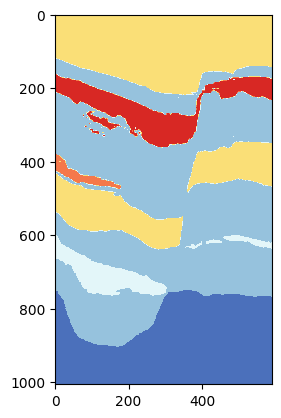

In [18]:
plt.imshow(image.squeeze().numpy(), cmap=label_cmap)
plt.show()